# **Accident Detection System**

**Importing libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import scipy.misc
import os 
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import zipfile
import csv
from google.colab import drive
import seaborn as sns
from time import time

**Monting google drive** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracting & Reading Zip File**

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/")
zip_ref.close()

In [ ]:
training_dir = '/content/drive/MyDrive/data/train/'
testing_dir = '/content/drive/MyDrive/data/test'
validation_dir = '/content/drive/MyDrive/data/val/'

In [ ]:
train_images = sum(len(files) for _,_, files in os.walk(training_dir))
test_images = sum(len(files) for _,_, files in os.walk(testing_dir))
validation_images = sum(len(files) for _,_, files in os.walk(validation_dir))

In [ ]:
print("Number of training images =",train_images)
print("Number of testing images =",test_images)
print("Number of validation images =",validation_images)

Number of training images = 791
Number of testing images = 100
Number of validation images = 98


**Data Generation**

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range= 0.1,
                                   height_shift_range= 0.1,
                                   zoom_range= 0.2,
                                   horizontal_flip= True,
                                   fill_mode= "nearest")
test_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
train_data = train_datagen.flow_from_directory(training_dir, class_mode='categorical', target_size=(224,224), batch_size=16)
test_data = test_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=16,shuffle=False)
valid_data = valid_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=16,shuffle=False)

Found 791 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


**Loading the pre-trained ResNet50 model**

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94781440/94765736 [==============================] - 1s 0us/step


ResNet50 model's architecture



In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

**Adding Fully Connected Layer on the top of pre-trained ResNet50 base layer**

In [ ]:
model = models.Sequential()

model.add(resnet_base)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49,278,594
Trainable params: 30,156,546
Non-trainable params: 19,122,048
_________________________________________________________________


**Freezing the pre-trained ResNet50 base**

In [ ]:
for layer in resnet_base.layers[:]:
  layer.trainable = False

full CNN model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49,278,594
Trainable params: 25,690,882
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
learning_rate = 1e-2

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = '/content/drive/MyDrive/resnet-cnn-model.h5',
        monitor = 'val_loss',
        save_best_only = True)]

**Do a round of fine-tuning of the entire model**

In [ ]:
resnet_base.trainable = True
set_trainable = False
for layer in resnet_base.layers:
  if 'conv5_block3' in layer.name:
    set_trainable= True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable= False

In [ ]:
for i, layer in enumerate(resnet_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_1 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49,278,594
Trainable params: 30,156,546
Non-trainable params: 19,122,048
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


**Fitting the Dataset into the Model**

In [ ]:
batch_size = 16
history = model.fit(train_data,
                             steps_per_epoch=train_images//batch_size,
                             epochs=40,
                             validation_data=valid_data,
                             validation_steps=validation_images//batch_size,
                             callbacks=callbacks_list)

Epoch 1/40
49/49 [==============================] - ETA: 0s - loss: 1.7629 - accuracy: 0.5729

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


49/49 [==============================] - 44s 619ms/step - loss: 1.7629 - accuracy: 0.5729 - val_loss: 0.5662 - val_accuracy: 0.7188
Epoch 2/40
49/49 [==============================] - 29s 582ms/step - loss: 0.6007 - accuracy: 0.6581 - val_loss: 0.5120 - val_accuracy: 0.7812
Epoch 3/40
49/49 [==============================] - 29s 582ms/step - loss: 0.5522 - accuracy: 0.7084 - val_loss: 0.3895 - val_accuracy: 0.8542
Epoch 4/40
49/49 [==============================] - 28s 562ms/step - loss: 0.5140 - accuracy: 0.7548 - val_loss: 0.3898 - val_accuracy: 0.8021
Epoch 5/40
49/49 [==============================] - 29s 589ms/step - loss: 0.4874 - accuracy: 0.7561 - val_loss: 0.3277 - val_accuracy: 0.8542
Epoch 6/40
49/49 [==============================] - 28s 575ms/step - loss: 0.4505 - accuracy: 0.7845 - val_loss: 0.3378 - val_accuracy: 0.8750
Epoch 7/40
49/49 [==============================] - 28s 574ms/step - loss: 0.4429 - accuracy: 0.7794 - val_loss: 0.3563 - val_accuracy: 0.8646
Epoch 8/40

In [ ]:
model = load_model("/content/drive/MyDrive/resnet-cnn-model.h5")

## **Plot the learning curves for Accuracy and Loss**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Accuracy', dpi=250)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Loss', dpi=250)
plt.show()

# **Evaluate the model**

**validtion the model**

In [ ]:
validation_datagen = ImageDataGenerator()
evaluate_datagen = validation_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 98 images belonging to 2 classes.


In [ ]:
print('Validate the model')
final_result = model.evaluate(
    evaluate_datagen,
    steps = validation_images)

Validate the model
98/98 [==============================] - 12s 26ms/step - loss: 0.0972 - accuracy: 0.9490


In [ ]:
t0 = time()
evaluate_datagen.reset()
val_predict = model.predict(
    evaluate_datagen,
    steps = validation_images,
    verbose = 1)
print('Time taken to evaluate the model:',int(time()-t0),'seconds')

98/98 [==============================] - 3s 25ms/step
Time taken to evaluate the model: 3 seconds


**classification for Validation dataset**

In [ ]:
validation_samples = val_predict.shape[0]
print('Number of data points in validation set:',validation_samples)

Number of data points in validation set: 98


In [ ]:
val_predicted_classes = np.argmax(val_predict, axis = 1)
val_true_classes = evaluate_datagen.classes
val_class_labels = list(evaluate_datagen.class_indices.keys())

In [ ]:
validation_report = metrics.classification_report(val_true_classes, val_predicted_classes, target_names=val_class_labels)
print('The validation report is as follows:')
print(validation_report)

The validation report is as follows:
              precision    recall  f1-score   support

    Accident       0.94      0.96      0.95        46
Non Accident       0.96      0.94      0.95        52

    accuracy                           0.95        98
   macro avg       0.95      0.95      0.95        98
weighted avg       0.95      0.95      0.95        98



**Performance metrics for validation set**

In [ ]:
val_conf_matrix = tf.math.confusion_matrix(labels=val_true_classes, predictions=val_predicted_classes).numpy()
print(val_conf_matrix)

[[44  2]
 [ 3 49]]


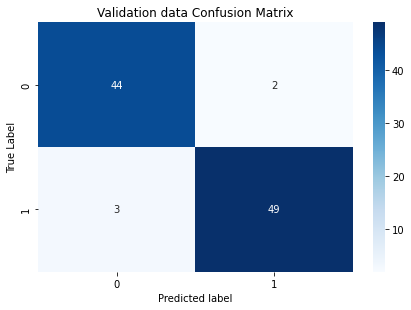

In [ ]:
figure1 = plt.figure()
sns.heatmap(val_conf_matrix, annot = True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.title("Validation data Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted label')

plt.savefig('Validation data Confusion Matrix', dpi=250)
plt.show()

**Test the model**

In [ ]:
testing_datagen = ImageDataGenerator()
test_data_datagen = testing_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 100 images belonging to 2 classes.


In [ ]:
print('Testing the model')
final_result = model.evaluate(
    test_data_datagen,
    steps = test_images)

Testing the model
100/100 [==============================] - 3s 26ms/step - loss: 0.1976 - accuracy: 0.9300


In [ ]:
test_data_datagen.reset()
predict_on_test_data = model.predict(
    test_data_datagen,
    steps = test_images,
    verbose = 1
)

100/100 [==============================] - 2s 23ms/step


In [ ]:
print('Number of data points in test set:',predict_on_test_data.shape[0])

Number of data points in test set: 100


**classification for Test dataset**

In [ ]:
predicted_classes = np.argmax(predict_on_test_data,axis=1)
predict_true_classes = test_data_datagen.classes
predict_class_labels = list(test_data_datagen.class_indices.keys())

**Performance metrics for Test set**

In [ ]:
test_report = metrics.classification_report(predict_true_classes, predicted_classes, target_names = predict_class_labels)
print(test_report)

              precision    recall  f1-score   support

    Accident       0.95      0.89      0.92        47
Non Accident       0.91      0.96      0.94        53

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [ ]:
test_confusion_matrix = tf.math.confusion_matrix(labels=predict_true_classes,predictions = predicted_classes).numpy()
print(test_confusion_matrix)

[[42  5]
 [ 2 51]]


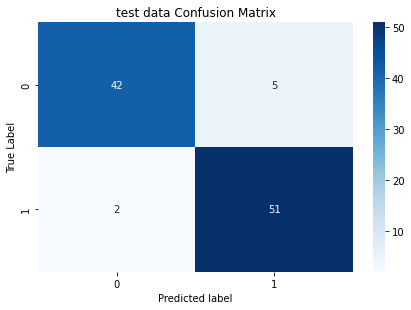

In [ ]:
figure1 = plt.figure()
sns.heatmap(test_confusion_matrix, annot = True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.title("test data Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Test data Confusion Matrix', dpi=250)
plt.show()

## **Predicting the image**

In [ ]:
IMG_CATEGORIES = {0: 'Accident', 1: 'No Accident'}

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
def pred_img(img_path):
  IMG_SIZE = 224
  img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), interpolation='nearest')
  prediction = model.predict(np.expand_dims(img, axis=0))
  result = np.argmax(prediction, axis=1)
  result = IMG_CATEGORIES.get(int(result))
  img = cv2.imread(img_path)
  cv2_imshow(img)
  print("Model's prediction:", result)

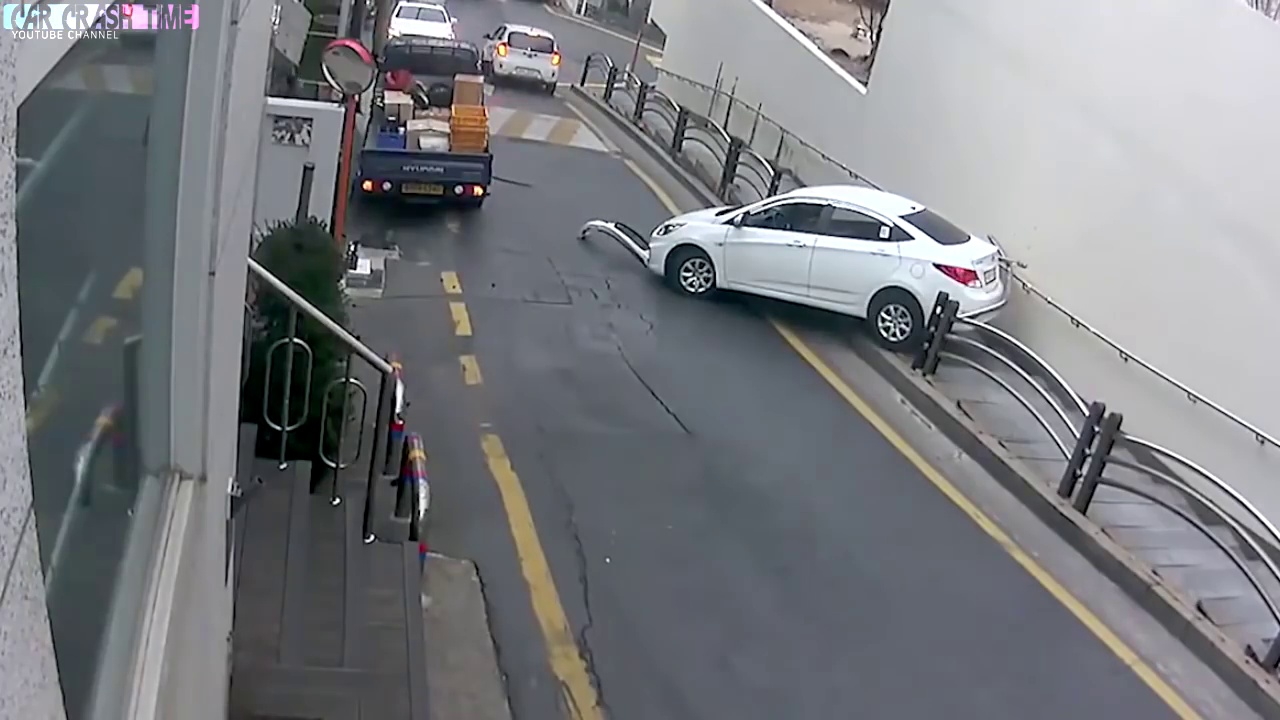

Model's prediction: Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Accident/test10_33.jpg')

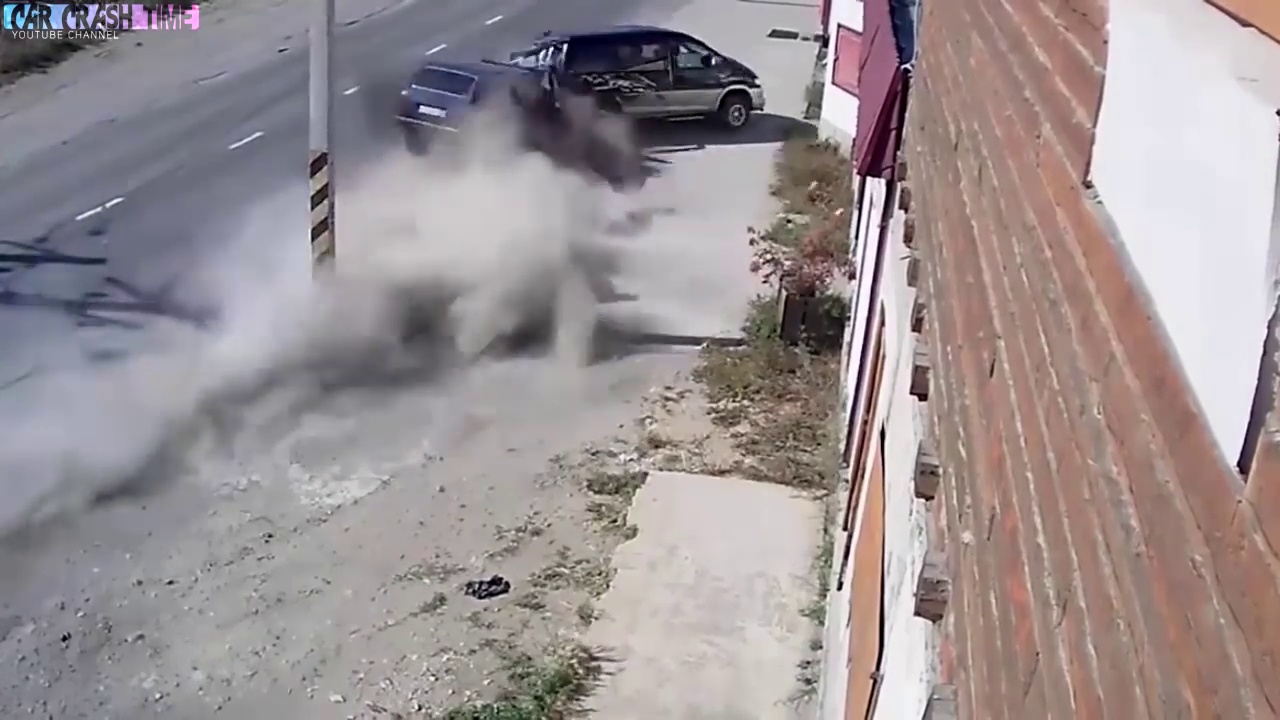

Model's prediction: Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Accident/test12_16.jpg')

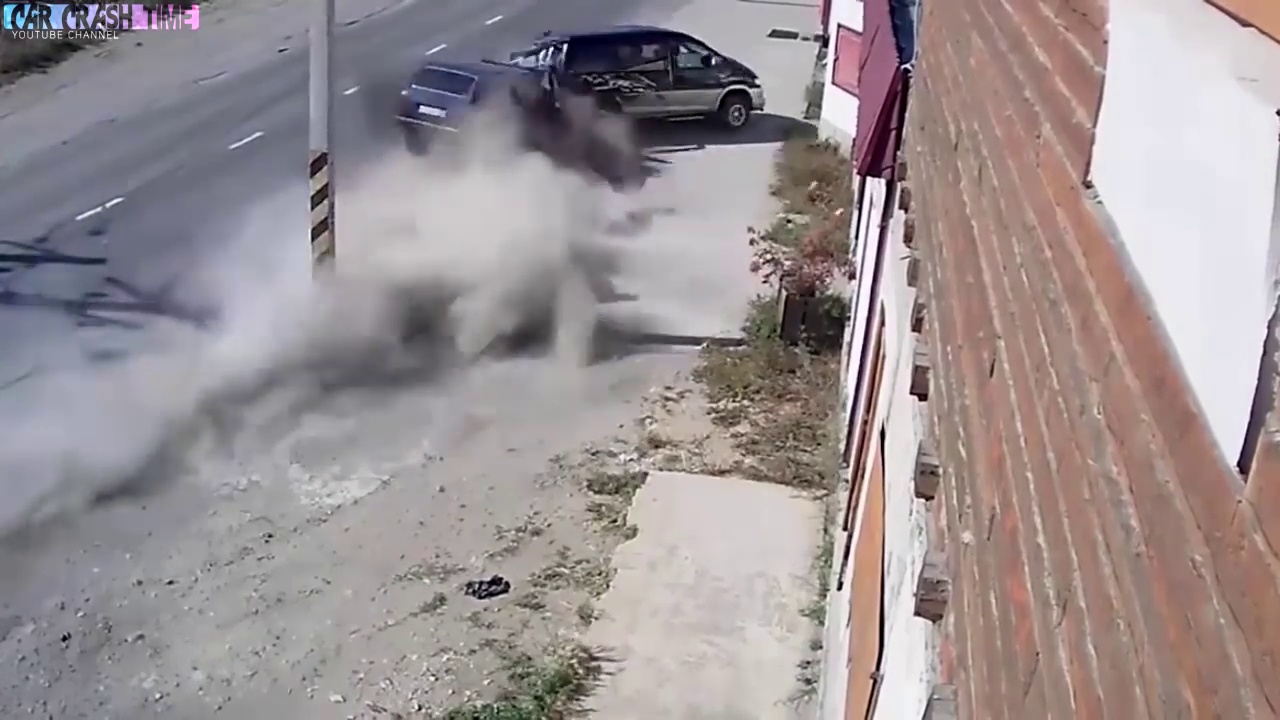

Model's prediction: Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Accident/test12_16.jpg')

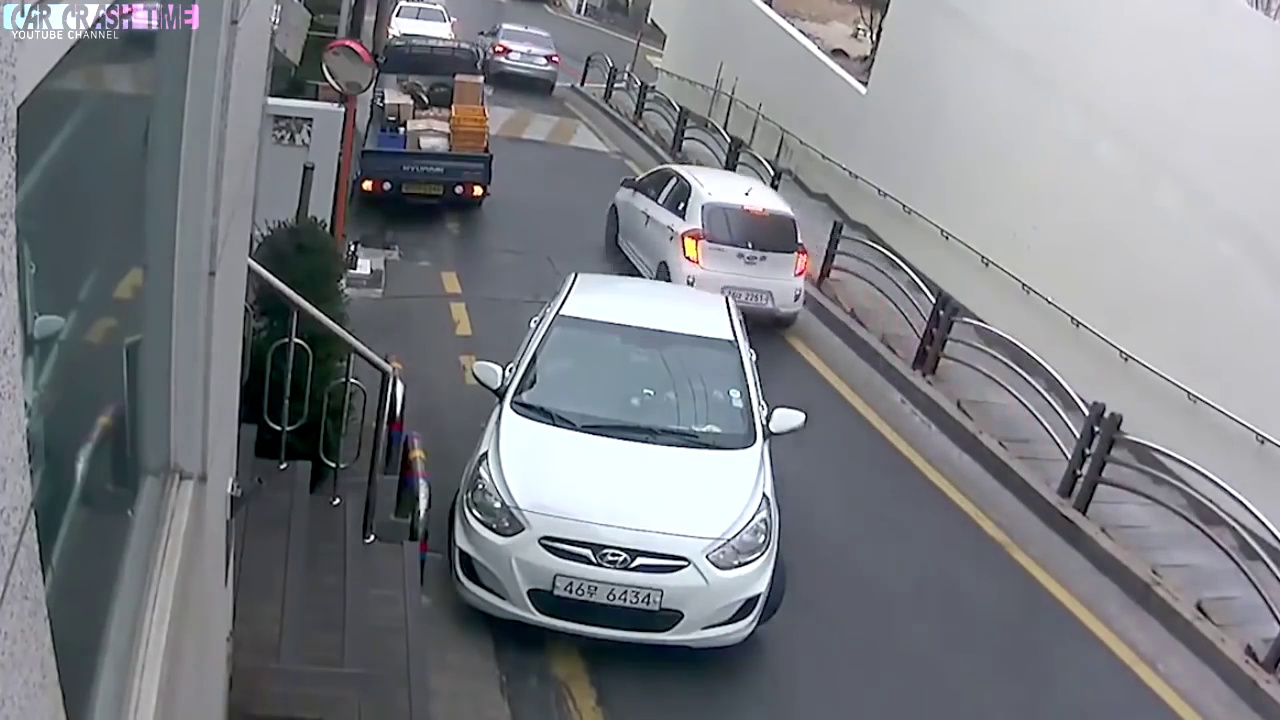

Model's prediction: No Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Non Accident/test10_5.jpg')

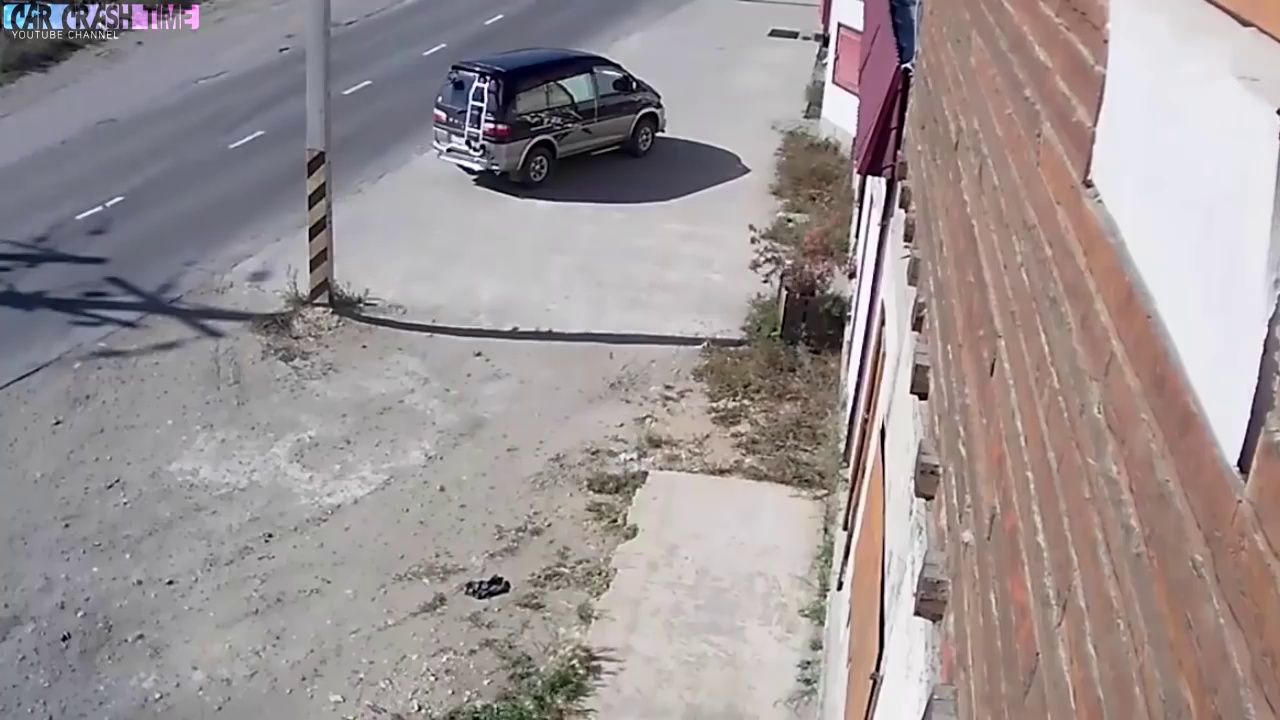

Model's prediction: No Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Non Accident/test12_1.jpg')

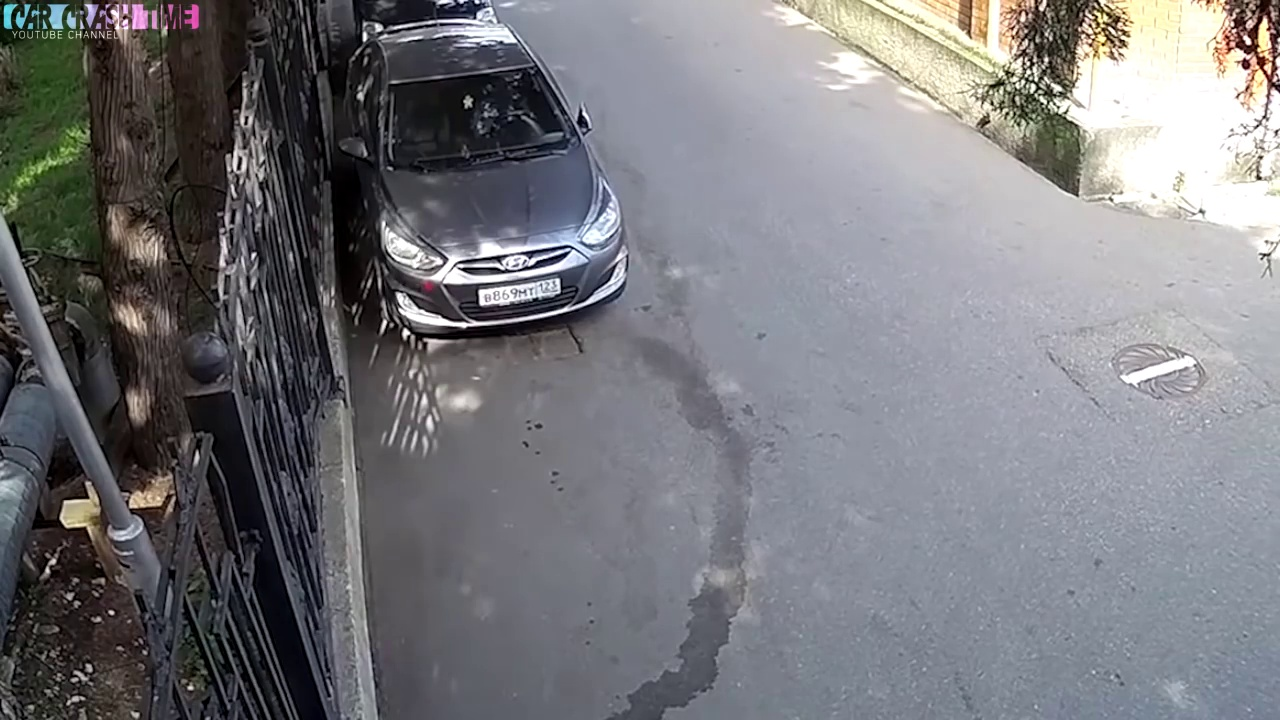

Model's prediction: No Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Non Accident/test27_5.jpg')

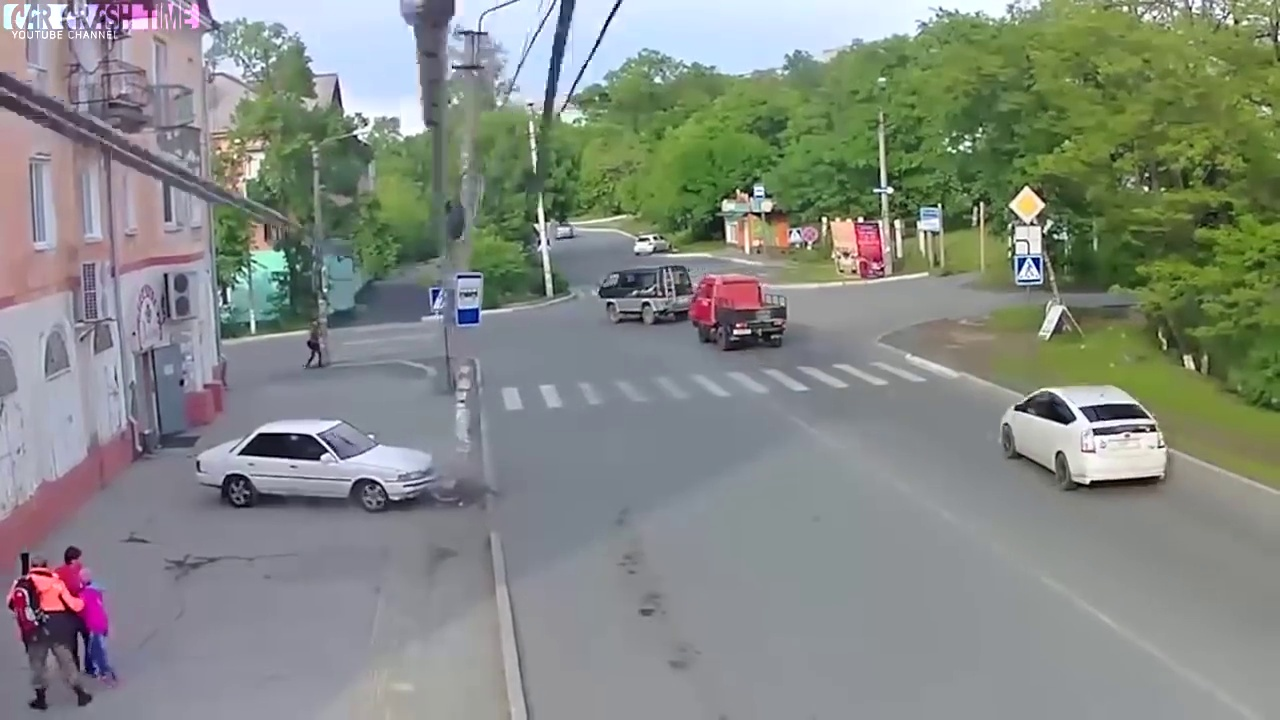

Model's prediction: Accident


In [ ]:
pred_img('/content/drive/MyDrive/data/test/Accident/test28_23.jpg')